In [5]:
import pandas as pd
import torch
import pickle
from argparse import Namespace
import re
import sys
import os
print('current path: ',os.getcwd())
current_path = os.getcwd()
working_dir = os.path.abspath(os.path.join(current_path, '..','..','..'))
if working_dir not in sys.path:
    sys.path.insert(0, working_dir)


from utils.utilities_DL import get_loss,load_model_and_optimizer
from build_inputs.load_datasets_to_predict import load_datasets_to_predict

trial_ids=['netmob_subway_in_calendar_STGCN_FeatureExtractor_ResNetInspired_MSELoss_2024_08_28_06_04_41108',
                 'netmob_subway_in_calendar_STGCN_ImageAvgPooling_MSELoss_2024_08_27_00_16_90667',
                 'netmob_subway_in_STGCN_FeatureExtractor_ResNetInspired_MSELoss_2024_08_23_06_53_46982',
                 'netmob_subway_in_STGCN_ImageAvgPooling_MSELoss_2024_08_24_01_42_17375',
                 'subway_in_calendar_STGCN_MSELoss_2024_08_25_22_56_92429',
                 'subway_in_STGCN_MSELoss_2024_08_25_18_05_25229']

save_path = 'save/K_fold_validation/training_with_HP_tuning'

current path:  /home/rrochas/prediction-validation


## Find all the fold save associated to a HP-tuning trial 

In [42]:
model_args = pickle.load(open(f'{os.getcwd()}{working_dir}/{save_path}/best_models/model_args.pkl','rb'))
# trial_id = 'subway_in_STGCN_MSELoss_2024_08_25_18_05_25229'
# trial_id =  'subway_in_subway_out_ASTGCN_MSELoss_2025_04_21_20_06_76371'

# HP tuning STAE former 200 epochs 
if False: 
    #trial_id = 'subway_in_calendar_STAEformer_MSELoss_2025_05_15_10_08_21638'
    trial_id = 'subway_in_netmob_POIs_calendar_STAEformer_MSELoss_2025_05_15_04_22_5433'

# STAE former 500 epochs 
if True: 
    trial_id =  'subway_in_netmob_POIs_calendar_STAEformer_MSELoss_2025_05_09_19_28_36371'
    trial_id = 'subway_in_netmob_POIs_calendar_STAEformer_MSELoss_2025_05_10_07_36_27059'
    trial_id =  'subway_in_netmob_POIs_calendar_STAEformer_MSELoss_2025_05_10_19_28_4752'
    #trial_id = 'subway_in_netmob_POIs_calendar_STAEformer_MSELoss_2025_05_11_07_23_58546'
    #trial_id = 'subway_in_netmob_POIs_calendar_STAEformer_MSELoss_2025_05_11_17_51_55895'
    #trial_id =  'subway_in_netmob_POIs_calendar_STAEformer_MSELoss_2025_05_12_04_10_74908'
best_model_names = [name for name in model_args['model'].keys() if trial_id in name]

re.pattern = re.compile(trial_id)
csv_trial_id = [name for name in os.listdir(f'{os.getcwd()}{working_dir}/{save_path}') if re.search(trial_id, name)]
print('CSV with saved metrics:')
display(csv_trial_id)

CSV with saved metrics:


['VALID_subway_in_netmob_POIs_calendar_STAEformer_MSELoss_2025_05_10_19_28_4752.csv',
 'Losses_subway_in_netmob_POIs_calendar_STAEformer_MSELoss_2025_05_10_19_28_4752.csv',
 'METRICS_subway_in_netmob_POIs_calendar_STAEformer_MSELoss_2025_05_10_19_28_4752.csv',
 'METRICS_BY_FOLDsubway_in_netmob_POIs_calendar_STAEformer_MSELoss_2025_05_10_19_28_4752.csv']

## Select one best model: 

In [43]:
selected_model_name = best_model_names[0]
args = model_args['model'][selected_model_name]['args']
perf = model_args['model'][selected_model_name]['performance']
losses_path = [csv_path for csv_path in csv_trial_id if 'Losses' in csv_path][0]
losses = pd.read_csv(f'{os.getcwd()}{working_dir}{save_path}/{losses_path}',index_col=0)
args = Namespace(**args)

In [19]:
mask

0     True
1    False
2    False
3    False
4    False
Name: col2, dtype: bool

In [98]:
import sys 
import os 
import pandas as pd
import numpy as np
import torch 
from datetime import datetime
current_file_path = os.path.abspath(os.getcwd())
parent_dir = os.path.abspath(os.path.join(current_file_path,'..'))
if parent_dir not in sys.path:
    sys.path.insert(0,parent_dir)

from utils.utilities import restrain_df_to_specific_period
from build_inputs.load_preprocessed_dataset import load_input_and_preprocess

def fill_nan_value_when_expected_freeflow(df: pd.DataFrame) -> pd.DataFrame:
    """
    Replace each NaN in the DataFrame (only from 00:00 to 05:00) with the average
    recorded for the same day of the week, the same hour, and the same minute.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame indexed by a DatetimeIndex, with arbitrary columns (sensors).
    
    Returns:
    --------
    pd.DataFrame
        Copy of the DataFrame with NaNs potentially filled for hours 00:00-05:00.
    """
    print('number of nan values before filling : ',df.isna().sum().sum())
    # Mask for night time : from midnight to 6 am  (excluded)
    night_mask = df.index.hour.isin(range(6))

    # Compute grouped mean (weekday, hour, minute):
    means = df.groupby([df.index.weekday, df.index.hour, df.index.minute]).transform('mean')

    # Mask of (time-slot, sensor) to fill : NaN and night time
    mask_night_and_NaN = night_mask[:, None] & df.isna()

    # Fill Values only if NaN within the mask 
    df_filled = df.where(~mask_night_and_NaN,means).copy()
    print('number of nan values after filling : ',df_filled.isna().sum().sum())
    return df_filled

def remove_sparse_sensor(df,limit_max_nan = 200):

    # Remove Sesor with too many NaN values: 
    s_nb_nan_per_columns = df.copy().isna().sum()
    sparse_columns = s_nb_nan_per_columns[s_nb_nan_per_columns>limit_max_nan].index
    filtered_df = df.drop(columns = sparse_columns)

    # Input missing data by clusteing:

    print('\nnb sparse_columns : ',len(sparse_columns))
    print('filtered_df : ',filtered_df.shape)


    return filtered_df,sparse_columns

FOLDER_PATH = f"{os.path.expanduser('~')}/../../data/rrochas/prediction_validation"
DATA_SUBFOLDER = 'CRITER_3_4_5_lanes'
NAME = 'flow'
START = '03/01/2019'
END = '06/01/2019'
USELESS_DATES = {'hour':[], #[1,2,3,4,5,6],  #[] if no useless (i.e removed) hours
                 'weekday':[]#[5,6],
                 }
FREQ = '6min'
list_of_invalid_period = []
list_of_invalid_period.append([datetime(2019,3,1,15,30),datetime(2019,3,1,15,42)])
list_of_invalid_period.append([datetime(2019,3,23,7,30),datetime(2019,3,23,9,0)])
list_of_invalid_period.append([datetime(2019,3,23,16,36),datetime(2019,3,23,20,12)])
list_of_invalid_period.append([datetime(2019,3,26,21,0),datetime(2019,3,26,21,12)])
list_of_invalid_period.append([datetime(2019,3,31,2,0),datetime(2019,3,31,3,0)])
C = 1
CITY = 'Lyon'
CHANNEL = 'DEBIT_HEURE'
taux_heure_limit = 100
limit_max_nan = 200
coverage_period = pd.date_range(start = START,end =END,freq = FREQ)[:-1]



# Load df: 
df = pd.read_csv(f"{FOLDER_PATH}/{DATA_SUBFOLDER}/{DATA_SUBFOLDER}.csv",index_col = 0)
df.HORODATE = pd.to_datetime(df.HORODATE)

# Mask forbidden values: 
mask = (df.TAUX_HEURE >= taux_heure_limit) | (df.DEBIT_HEURE < 0)
df.loc[mask,['TAUX_HEURE','DEBIT_HEURE']] = np.nan

# Pivot df : 
pivoted_df = df.pivot_table(index = 'HORODATE',columns = 'ID_POINT_MESURE',values =CHANNEL).sort_index()
reindex = pd.date_range(start = START,end =END,freq = FREQ)[:-1]

invalid_dates = reindex.difference(pivoted_df.index)
print(f"Number of invalid time-slots (i.e data when every single sensors does not have data): {len(invalid_dates)}")
pivoted_df = pivoted_df.reindex(reindex)
pivoted_df = restrain_df_to_specific_period(pivoted_df,coverage_period)

# Fill values if expected during nightime (freeflow):
df_filled = fill_nan_value_when_expected_freeflow(pivoted_df)

# Fill remaining NaN by interpolation but limited with only one NaN value 
df_interpolated = df_filled.interpolate(limit=1)

filtered_df,sparse_columns = remove_sparse_sensor(df_interpolated,limit_max_nan+len(invalid_dates))
print('Number of sensors after filter sparse sensor : ',len(filtered_df.columns))
print(f" Data loaded with shape: {filtered_df.shape}")
filtered_df.head()






Number of invalid time-slots (i.e data when every single sensors does not have data): 82
number of nan values before filling :  609379
number of nan values after filling :  526946

nb sparse_columns :  96
filtered_df :  (22080, 51)
Number of sensors after filter sparse sensor :  51
 Data loaded with shape: (22080, 51)


ID_POINT_MESURE,15,48,50,54,56,64,65,66,67,74,...,906,911,916,994,999,1000,1066,1176,1217,1795
2019-03-01 00:00:00,260.0,540.0,480.0,70.0,280.0,110.0,110.0,170.0,120.0,480.0,...,430.0,620.0,270.0,70.0,120.0,230.0,90.0,160.0,540.0,390.0
2019-03-01 00:06:00,440.0,570.0,420.0,90.0,320.0,230.0,110.0,240.0,200.0,340.0,...,310.0,640.0,190.0,70.0,200.0,250.0,20.0,160.0,390.0,310.0
2019-03-01 00:12:00,350.0,390.0,360.0,90.0,190.0,140.0,120.0,290.0,90.0,370.0,...,330.0,580.0,290.0,80.0,80.0,240.0,30.0,120.0,360.0,310.0
2019-03-01 00:18:00,290.0,450.0,280.0,100.0,320.0,140.0,80.0,180.0,80.0,410.0,...,230.0,500.0,170.0,40.0,80.0,240.0,70.0,130.0,330.0,410.0
2019-03-01 00:24:00,170.0,320.0,280.0,80.0,140.0,130.0,130.0,170.0,80.0,270.0,...,430.0,440.0,210.0,40.0,70.0,160.0,80.0,110.0,160.0,330.0


ID_POINT_MESURE,15,48,50,54,56,64,65,66,67,74,...,906,911,916,994,999,1000,1066,1176,1217,1795
2019-03-06 02:00:00,120.000000,120.0,60.0,40.0,10.0,80.0,10.0,90.0,30.0,140.0,...,20.0,160.0,90.0,30.0,30.0,90.0,10.0,10.0,110.0,100.0
2019-03-06 02:06:00,116.666667,150.0,20.0,40.0,40.0,60.0,60.0,70.0,0.0,120.0,...,50.0,190.0,60.0,20.0,0.0,60.0,10.0,10.0,110.0,90.0
2019-03-06 02:12:00,110.000000,80.0,70.0,20.0,0.0,90.0,120.0,90.0,20.0,90.0,...,40.0,130.0,20.0,0.0,30.0,100.0,10.0,30.0,70.0,80.0
2019-03-06 02:18:00,80.000000,120.0,90.0,10.0,50.0,30.0,70.0,60.0,20.0,70.0,...,50.0,160.0,80.0,10.0,10.0,60.0,20.0,20.0,10.0,80.0
2019-03-06 02:24:00,80.000000,150.0,80.0,10.0,80.0,70.0,10.0,90.0,0.0,20.0,...,20.0,180.0,60.0,20.0,0.0,70.0,20.0,40.0,60.0,110.0
2019-03-06 02:30:00,77.500000,100.0,10.0,40.0,70.0,40.0,30.0,50.0,40.0,60.0,...,20.0,130.0,60.0,10.0,40.0,40.0,50.0,10.0,30.0,60.0
2019-03-06 02:36:00,103.333333,60.0,80.0,20.0,40.0,50.0,40.0,80.0,30.0,30.0,...,30.0,120.0,80.0,10.0,30.0,100.0,10.0,50.0,30.0,70.0
2019-03-06 02:42:00,98.333333,120.0,80.0,0.0,50.0,80.0,40.0,130.0,10.0,150.0,...,40.0,150.0,70.0,30.0,10.0,120.0,10.0,20.0,50.0,80.0
2019-03-06 02:48:00,82.500000,110.0,60.0,10.0,30.0,60.0,10.0,100.0,0.0,40.0,...,30.0,170.0,60.0,30.0,0.0,80.0,10.0,0.0,60.0,70.0
2019-03-06 02:54:00,80.000000,90.0,50.0,40.0,40.0,50.0,0.0,90.0,10.0,50.0,...,30.0,150.0,40.0,0.0,10.0,100.0,20.0,10.0,70.0,110.0


In [78]:
means.shape,df_filled.shape,df.shape,fill_mask.shape

((22080, 50), (22080, 50), (22080, 50), (22080, 50))

ID_POINT_MESURE,15,48,50,54,56,64,65,66,67,74
2019-03-31 02:00:00,322.5,532.5,344.166667,53.333333,370.0,280.833333,107.5,313.333333,106.666667,433.333333
2019-03-31 02:06:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-31 02:12:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-31 02:18:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-31 02:24:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-31 02:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-31 02:36:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-31 02:42:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-31 02:48:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-31 02:54:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


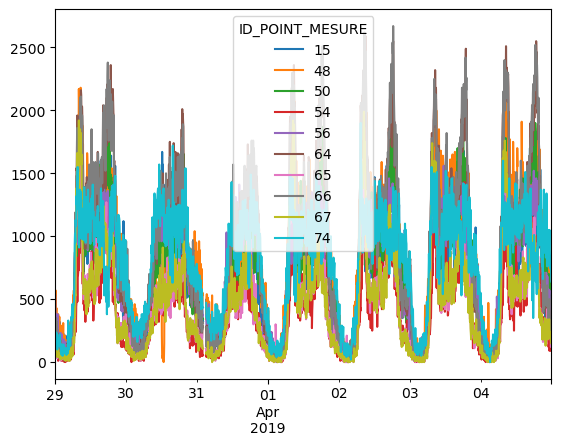

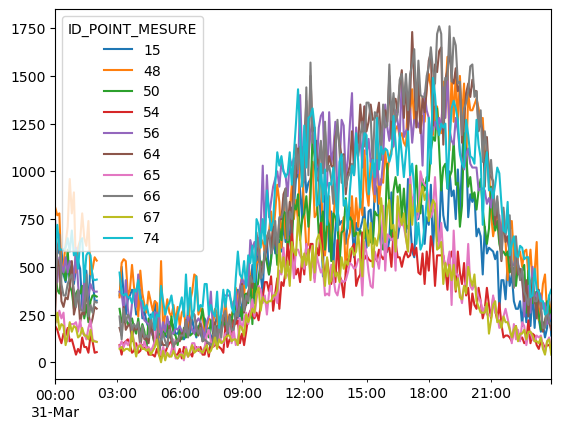

In [45]:
day = 28 # 14

d = 2
week = 10*24*7
heure = 2
nb_col = 10
filtered_df.iloc[10*24*day :10*24*day+week].iloc[:,:nb_col].plot()
filtered_df.iloc[10*24*(day+d) :10*24*(day+d+1)].iloc[:,:nb_col].plot()

display(filtered_df.iloc[10*24*(day+d)+10*heure :10*24*(day+d)+10*(heure+3),:nb_col])

## Print Losses through epochs: 

In [44]:
from plotting.TS_analysis import plot_TS
plot_TS(losses,width=1200,height=400,bool_show=True,title=f"Losses through epochs",x_datetime = False)

Loading BokehJS ...

figure(id='p2261', ...)

## Print its associated best Metrics: 

In [31]:
model_args['model'][model_name]['performance']['valid_metrics']

{'mse_h1': 1700.475341796875,
 'mae_h1': 25.01986312866211,
 'mape_h1': 36.47563552856445,
 'mase_h1': 0.7625378966331482,
 'mse_h2': 2073.196533203125,
 'mae_h2': 27.27683448791504,
 'mape_h2': 41.670291900634766,
 'mase_h2': 0.8316004276275635,
 'mse_h3': 2118.075927734375,
 'mae_h3': 27.377107620239258,
 'mape_h3': 43.38100814819336,
 'mase_h3': 0.8371695280075073,
 'mse_h4': 2115.8828125,
 'mae_h4': 27.28019905090332,
 'mape_h4': 45.34933853149414,
 'mase_h4': 0.8433877825737,
 'mse_all': 2001.9076538085938,
 'mae_all': 26.73850107192993,
 'mape_all': 41.71906852722168,
 'mase_all': 0.8186739087104797}

In [19]:
import numpy as np 
valid_mae = []
valid_mse = []
test_mae = []
test_mse = []

for model_name in best_model_names:
    valid_mae.append(model_args['model'][model_name]['performance']['valid_metrics']['mae'])
    test_mae.append(model_args['model'][model_name]['performance']['test_metrics']['mae'])
    valid_mse.append(model_args['model'][model_name]['performance']['valid_metrics']['mse'])
    test_mse.append(model_args['model'][model_name]['performance']['test_metrics']['mse'])


df_losses = pd.DataFrame([valid_mae,valid_mse,test_mae,test_mse],columns = [f"fold_{k}" for k in range(len(valid_losses))],index = ['Valid MAE','Valid MSE','Test MAE','Test MSE'])
display(df_losses)

KeyError: 'mae'

## Load the model and its weights:

In [ ]:
from calendar_class import get_time_slots_labels
from constants.paths import FILE_NAME
from utils.utilities_DL match_period_coverage_with_netmob

selected_model_path = f"{working_dir}/{save_path}/{selected_model_name}.pkl"
model_param = torch.load(selected_model_path)

# Load Model:
coverage_period = match_period_coverage_with_netmob(FILE_NAME,dataset_names=['subway_in','netmob'])
dataset,_,_ = load_datasets_to_predict(args,coverage_period)
_,dic_class2rpz,_,_ = get_time_slots_labels(dataset,nb_class = [0,1,2,3])
loss_function = get_loss(args)
model,optimizer,scheduler = load_model_and_optimizer(args,dic_class2rpz)

# Associate its weights: 
model.load_state_dict(model_param['state_dict'])

Time-step per hour: 4.0
coverage period: 2019-03-16 00:00:00 - 2019-05-31 23:45:00

Init Subway-In Dataset:  torch.Size([7392, 40])
Number of Nan Value:  tensor(0)
Total Number of Elements:  295680 


 Tackling Training Set

 Tackling Validation Set

 Tackling Testing Set

 Tackling Training Set

 Tackling Validation Set

 Tackling Testing Set

U size:  torch.Size([6719, 40, 7]) Utarget size:  torch.Size([6719, 40, 1])
U_train size:  torch.Size([3912, 40, 7]) Utarget_train size:  torch.Size([3912, 40, 1])
U_valid size:  torch.Size([1304, 40, 7]) Utarget_valid size:  torch.Size([1304, 40, 1])
U_test size:  torch.Size([1310, 40, 7]) Utarget_test size:  torch.Size([1310, 40, 1])
U_train min:  tensor(0.) U_train max:  tensor(1.)
U_valid min:  tensor(0.) U_valid max:  tensor(1.7234)
U_test min:  tensor(0.) U_test max:  tensor(2.2126)
model size: 0.001GB
number of total parameters: 249889
number of trainable parameters: 249889


<All keys matched successfully>